You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os

#"""
!rm k -r
if not os.path.isdir('k'):
 !git clone -b development15 https://github.com/joaopauloschuler/k-neural-api.git k
 !cd k && git log -1
#else:
# !cd k && git pull
#"""
!cd k && pip install .

rm: cannot remove 'k': No such file or directory
Cloning into 'k'...
remote: Enumerating objects: 1524, done.
remote: Counting objects: 100% (973/973), done.
remote: Compressing objects: 100% (636/636), done.
remote: Total 1524 (delta 707), reused 579 (delta 334), pack-reused 551
Receiving objects: 100% (1524/1524), 15.05 MiB | 19.89 MiB/s, done.
Resolving deltas: 100% (1063/1063), done.
commit b8eaeb0c78b972b91e38566f488ad3df24d16f64 (HEAD -> development15, origin/development15)
Author: joaopauloschuler <jp@schulers.com>
Date:   Sun Jan 23 15:05:04 2022 +0100

    Prevents gradient ascent type errors.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://githu

In [2]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
from tensorflow import keras
from tensorflow.keras import mixed_precision
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.767017984 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Sun Jan 30 12:34:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# mixed_precision.set_global_policy('mixed_float16')

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
dataset=tf.keras.datasets.cifar10
verbose=True
lab=False
bipolar=False
base_model_name='JP'
x_train, y_train, x_test, y_test = cai.datasets.load_dataset(dataset, verbose=verbose, lab=lab, bipolar=bipolar, base_model_name=base_model_name)
print(x_train.shape)
print(y_train.shape)

170508288/170498071 [==============================] - 6s 0us/step
train shape (50000, 32, 32, 3)
test shape (10000, 32, 32, 3)
Original channel  0  min: 0.0  max: 255.0
Original channel  1  min: 0.0  max: 255.0
Original channel  2  min: 0.0  max: 255.0
Loading RGB.
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
(50000, 32, 32, 3)
(50000, 10)


In [7]:
num_classes = 10
batch_size = 64
epochs = 180
target_size_x = 32
target_size_y = 32
seed = 12

In [8]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [9]:
train_datagen = cai.util.create_image_generator(validation_split=0.1, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0)
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler30(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 30
    result = base_learning
    if local_epoch < 7:
       result = base_learning * (1 + 0.5*local_epoch)
    else:
       result = (base_learning * 4) * ( 0.85**(local_epoch-7) )

    if result < 2.5245e-04:
      result = 2.5245e-04
    return result

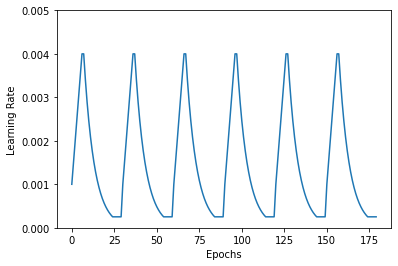

In [10]:
learning_rate_test = []
for epoch in range(epochs):
  learning_rate_test.append( cyclical_adv_lrscheduler30(epoch) )
plt.figure()
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.ylim([0.0000,0.005])
plt.plot(learning_rate_test)

In [11]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_loss'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [cai.layers.D6v3_32ch()]: #
      basefilename = '/content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      model = cai.efficientnet.kEfficientNetB0(
        include_top=True,
        skip_stride_cnt=3,
        input_shape=input_shape,
        classes=num_classes,
        kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      # optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary(line_length=180)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='training'
            )
            validation_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=False,
                seed=seed,
                subset='validation'
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler30)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=False,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        cai.datasets.test_flips_on_saved_model(x_test, y_test, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=True, center_crop=0.15)
      print('Finished: '+basefilename)

# Show Models

In [12]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33
Model: "kEffNet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 32, 32, 3)]                     0                    []                                                          
                                                                                                                                                                                    
 k_stem_conv_pad (ZeroPadding2D)                           (None, 33, 33, 3)                       0                    ['input_1[0][0]']                                           
   

# Fitting

Running: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33
Epoch 1/180
704/704 [==============================] - ETA: 0s - loss: 2.3337 - accuracy: 0.2321
Epoch 00001: val_loss improved from inf to 2.28793, saving model to /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


704/704 [==============================] - 156s 172ms/step - loss: 2.3337 - accuracy: 0.2321 - val_loss: 2.2879 - val_accuracy: 0.2674 - lr: 0.0010
Epoch 2/180
704/704 [==============================] - ETA: 0s - loss: 1.7156 - accuracy: 0.3677
Epoch 00002: val_loss improved from 2.28793 to 1.74928, saving model to /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33-best_result.hdf5
704/704 [==============================] - 118s 168ms/step - loss: 1.7156 - accuracy: 0.3677 - val_loss: 1.7493 - val_accuracy: 0.4284 - lr: 0.0015
Epoch 3/180
704/704 [==============================] - ETA: 0s - loss: 1.4049 - accuracy: 0.4920
Epoch 00003: val_loss did not improve from 1.74928
704/704 [==============================] - 115s 162ms/step - loss: 1.4049 - accuracy: 0.4920 - val_loss: 2.4606 - val_accuracy: 0.3960 - lr: 0.0020
Epoch 4/180
704/704 [==============================] - ETA: 0s - loss: 1.2207 - accuracy: 0.5672
Epoch 00004: val_loss improved from 1.74928 to 1.57888, saving

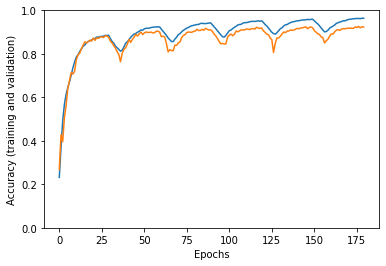

In [13]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [14]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33
Best Model Results: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33-best_result.hdf5
157/157 [==============================] - 8s 39ms/step - loss: 0.2128 - accuracy: 0.9445
loss 0.21279433369636536
acc 0.9445000290870667
Finished: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33


In [15]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=True)

Running: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33
Best Model Results: /content/drive/MyDrive/output/JP30I02j-EfficientNet-CIFAR10-33-best_result.hdf5
157/157 [==============================] - 9s 39ms/step - loss: 0.2128 - accuracy: 0.9445
loss 0.21279433369636536
acc 0.9445000290870667
Test Original
              precision    recall  f1-score   support

           0     0.9519    0.9490    0.9504      1000
           1     0.9645    0.9770    0.9707      1000
           2     0.9281    0.9290    0.9285      1000
           3     0.8982    0.8820    0.8900      1000
           4     0.9499    0.9490    0.9495      1000
           5     0.9211    0.8990    0.9099      1000
           6     0.9419    0.9730    0.9572      1000
           7     0.9707    0.9610    0.9658      1000
           8     0.9582    0.9630    0.9606      1000
           9     0.9592    0.9630    0.9611      1000

    accuracy                         0.9445     10000
   macro avg     0.9444   